In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.classifier import confusion_matrix, class_prediction_error

from sklearn.metrics import accuracy_score

## ***0 Описание задачи***

Определение качества вина с помощью анализа физико-химических свойств.

## ***1 Загрузка датасета***

Датасет представлен в виде двух csv файлах. Каждый из них соответствует красному и белому вину. Объединим эти два csv файла в один. Для этого добавим в каждый из csv файлов столбец "тип вина" и затем объединим их.

In [2]:
url_red = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data_raw_red = pd.read_csv(url_red, ";")
data_raw_red['type'] = "red"

url_white = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data_raw_white = pd.read_csv(url_white, ";")
data_raw_white["type"] = "white"

data_raw = pd.concat([data_raw_red, data_raw_white], ignore_index=True)

Рассмотрим признаки в датасете:

In [3]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [4]:
data_raw["quality"]

0       5
1       5
2       5
3       6
4       5
       ..
6492    6
6493    5
6494    6
6495    7
6496    6
Name: quality, Length: 6497, dtype: int64

Признак "quality" является оценкой в диапазоне от 1 до 10.
Введем новый признак тип качества:

* 0 (плохое) (quality 1-4)
* 1 (обычное) (quality 5-7)
* 2(хорошее) (quality 8-10)

In [5]:
conditions = [
    data_raw['quality'] >= 8,
    data_raw['quality'] < 5,
]

choices = [2, 0]

data_raw['type_quality'] = np.select(conditions, choices, default=1)

In [6]:
data_raw["type_quality"]

0       1
1       1
2       1
3       1
4       1
       ..
6492    1
6493    1
6494    1
6495    1
6496    1
Name: type_quality, Length: 6497, dtype: int64

Опишем каждый из признаков:

In [7]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
 13  type_quality          6497 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 710.7+ KB


fixed acidity - фиксированная кислотность - числовой
0.   fixed acidity - фиксированная кислотность - числовой
1.   volatile acidity - летучая кислотность - числовой
2.   citric acid - лимонная кислота - числовой
3.  residual sugar - остаточный сахар - числовой
4.  chlorides - хлориды - числовой
5. free sulfur dioxide - свободный диоксид серы - числовой
6. total sulfur dioxide - общий диоксид серы - числовой
7. density - плотность - числовой
8. pH - водородный показатель - числовой
9. sulphates - сульфаты - числовой
10. alcohol - содержание алкоголя - числовой
11. quality - качество вина (оценка от 0 до 10) - числовой
12. type - тип вина (белое или красное) - категориальный (red, white)
13. type_quality - качество вина (оценка от 0 до 2) - числовой

## ***2 Визуализация данных. Вычисление основных характеристик***

Вычислим основные характеристики:

In [8]:
data_raw.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  type_quality  
count  6497.000000  6497.000000  6497.000000  6497.000000   6497.000000  
mean      3.218501     0.531268    10.491801     5.818378      0.992612  
std       0.160787     0.148806     1.192712     0.873255      0.261333  
min       2.720000     0.220000     8.000000     3.000000      0.000000  
25%       3.110000     0.430000     9.500000     5.000000      1.000000  
50%       3.210000     0.510000    10.300000     6.000000      1.000000  
75%       3.320000     0.600000    11.300000     6.000000      1.000000  
max       4.010000     2.000000    14.900000     9.000000      2.000000

Построим диаграммы для таких признаков как тип вина и его качество

Text(0, 0.5, 'Количество вина')

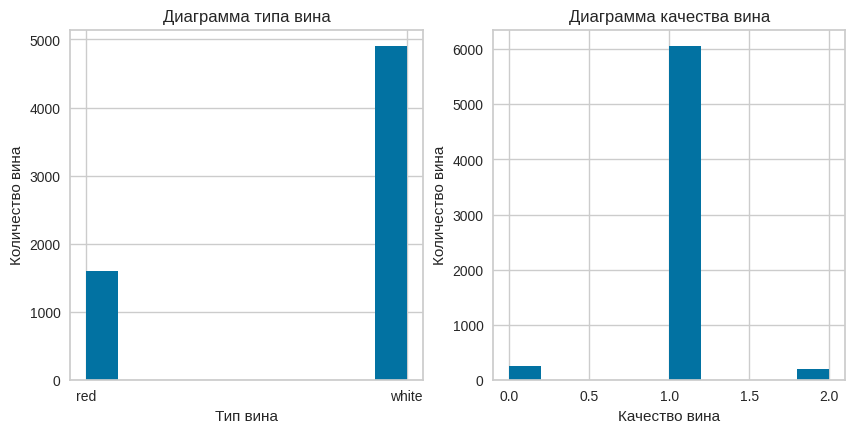

In [9]:
fig = plt.figure(figsize = (10, 10))
ax_1 = fig.add_subplot(2, 2, 1)
ax_2 = fig.add_subplot(2, 2, 2)

ax_1.hist(data_raw.loc[:, "type"])
ax_1.set_title('Диаграмма типа вина')
ax_1.set_xlabel("Тип вина")
ax_1.set_ylabel("Количество вина")

ax_2.hist(data_raw.loc[:, "type_quality"])
ax_2.set_title('Диаграмма качества вина');
ax_2.set_xlabel("Качество вина")
ax_2.set_ylabel("Количество вина")

Из диаграмм можно сделать вывод о том, что большинство вин являются белыми и распространены "обычные"

Рассмотрим зависимость качества вина от фиксированной кислотности:

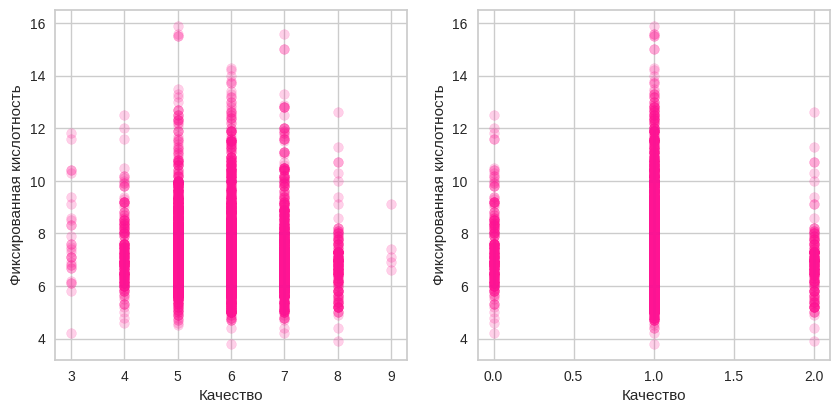

In [10]:
fig = plt.figure(figsize = (10, 10))
ax_1 = fig.add_subplot(2, 2, 1)
ax_2 = fig.add_subplot(2, 2, 2)

ax_1.scatter(data_raw['quality'], data_raw['fixed acidity'],
            alpha=0.2, color = "deeppink")
ax_1.set_xlabel('Качество')
ax_1.set_ylabel('Фиксированная кислотность');

ax_2.scatter(data_raw['type_quality'], data_raw['fixed acidity'],
            alpha=0.2, color = "deeppink")
ax_2.set_xlabel('Качество')
ax_2.set_ylabel('Фиксированная кислотность');

Из диаграмм можно сделать вывод о том, что большая часть хорошего вина имеет кислотность от 5 до 8, а кислотность вина среднего качества может быть любой.

Теперь рассмотрим зависимость качества от плотности

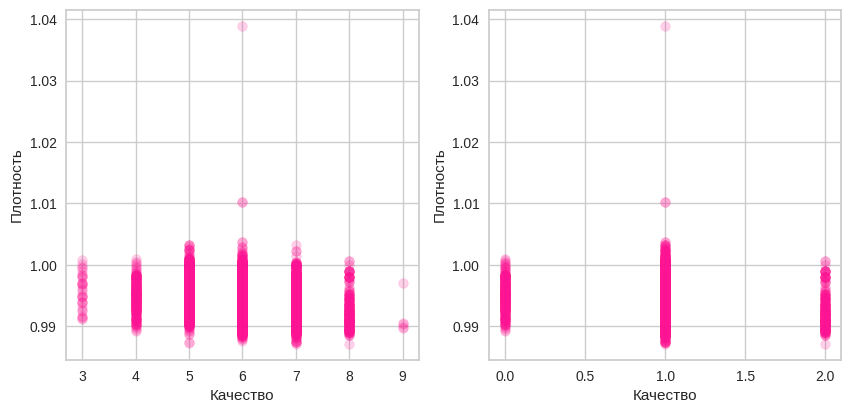

In [11]:
fig = plt.figure(figsize = (10, 10))
ax_1 = fig.add_subplot(2, 2, 1)
ax_2 = fig.add_subplot(2, 2, 2)

ax_1.scatter(data_raw['quality'], data_raw['density'],
            alpha=0.2, color = "deeppink")
ax_1.set_xlabel('Качество')
ax_1.set_ylabel('Плотность');

ax_2.scatter(data_raw['type_quality'], data_raw['density'],
            alpha=0.2, color = "deeppink")
ax_2.set_xlabel('Качество')
ax_2.set_ylabel('Плотность');

Исходя из диаграмм можем сделать вывод о том, что вино в среднем имеет одинаковую плотность. Также можно заметить несколько незначительных "выбросов"

Построим диаграммы рассеивания

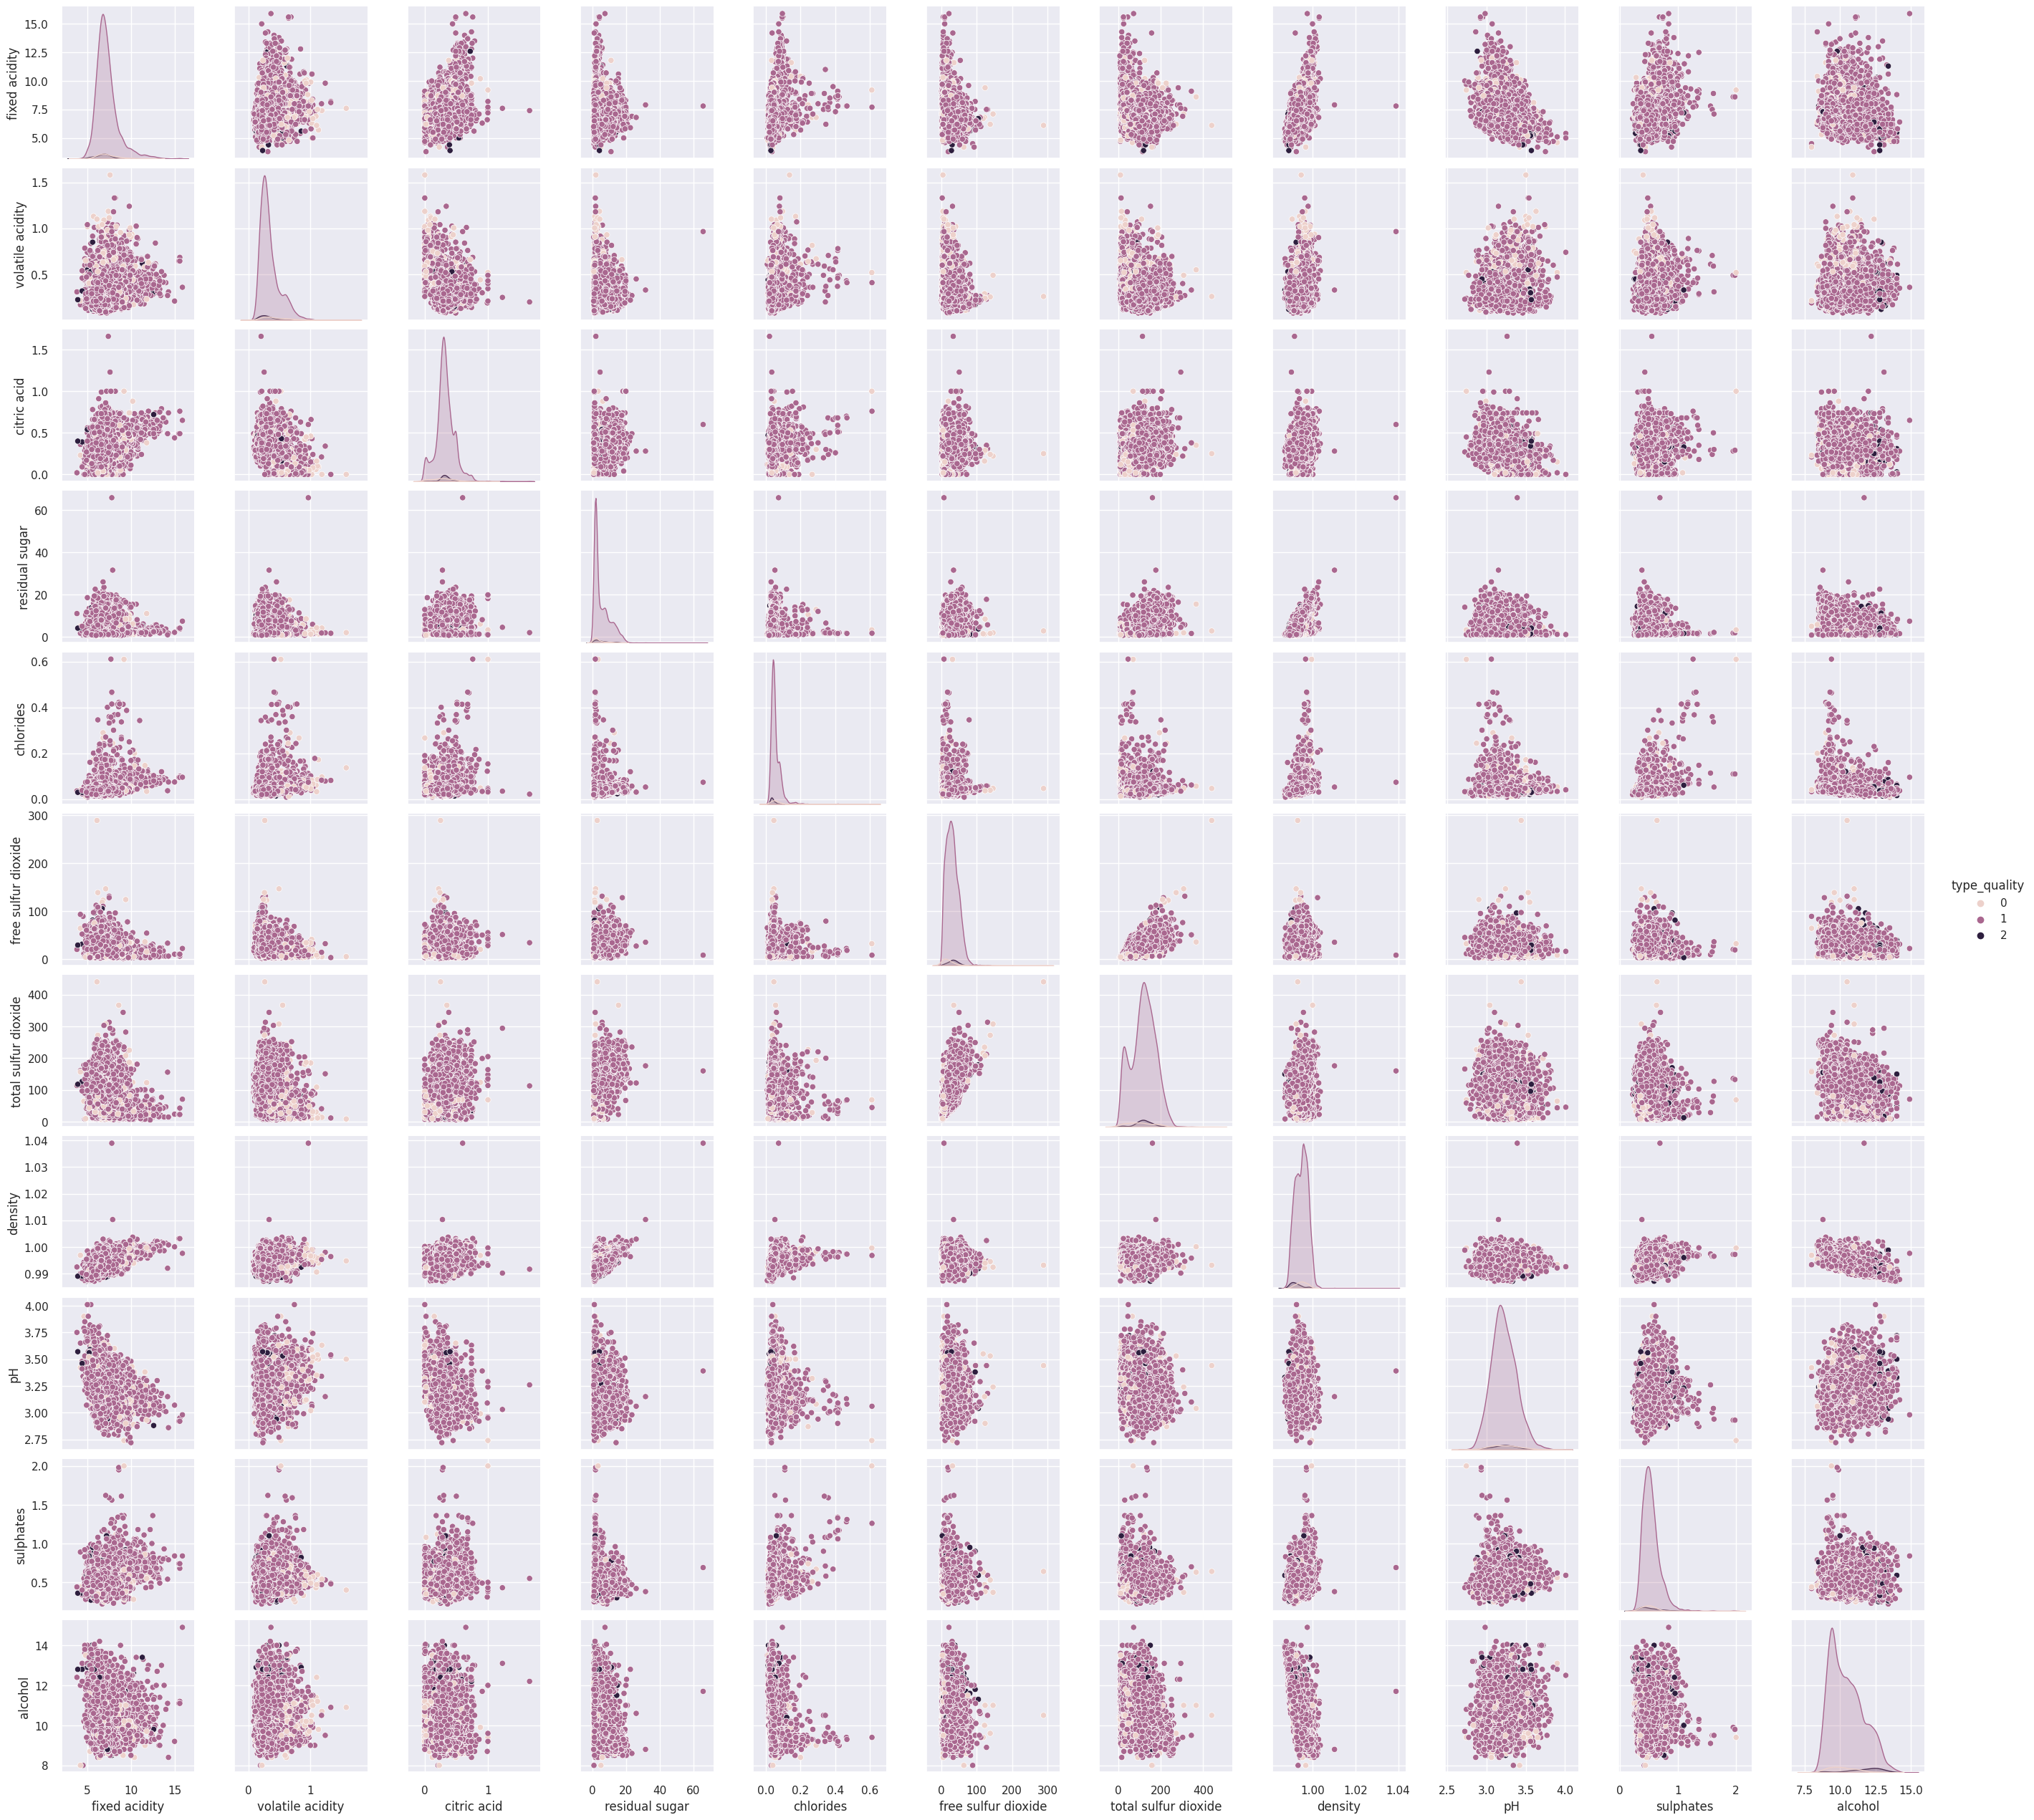

In [12]:
sns.set(font_scale=1.0)
cols = data_raw.columns
cols = cols.drop('quality')
g = sns.pairplot(data = data_raw.loc[:, cols], hue='type_quality')
fig = g.fig
fig.subplots_adjust(top=0.93, wspace=0.3)

Построим матрицу корреляции

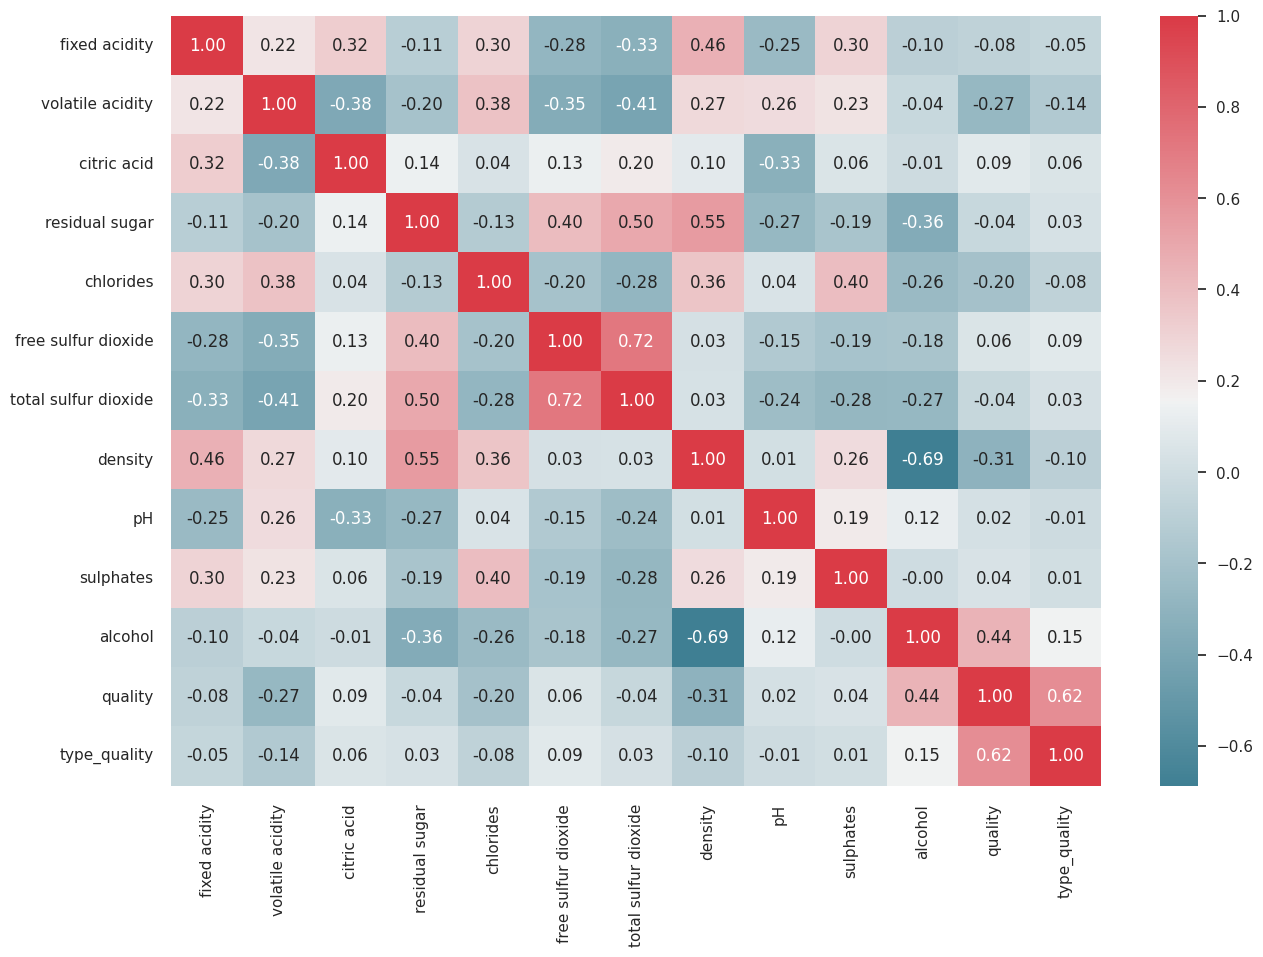

In [13]:
corr_mat = data_raw.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f")
sns.set(font_scale=1.0)

Выведем признаки, для которых коэффициенты корреляции > 0.5, для остальных признаков можно сказать, что связь между ними слабая:

In [14]:
corr_mat.where(np.triu(corr_mat > 0.5, k=1)).stack().sort_values(ascending=False)

free sulfur dioxide  total sulfur dioxide    0.720934
quality              type_quality            0.616734
residual sugar       density                 0.552517
dtype: float64

Корреляции объяснимы следующим:


*   свободный диоксид серы входит в общий диоксид серы
*   тип качества это производная от качества
*   сахар является плотным следовательно повышается общая плотность вина

 ## ***3 Обработка пропущенных значений***

In [15]:
data_raw.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
type_quality            0
dtype: int64

## 4. ***Обработка категориальных признаков***

Тип вина является object. Приведем его к бинарному

In [16]:
data_raw['type'] = pd.factorize(data_raw['type'])[0]

## 4. ***Нормализация***

In [17]:
data_stand = (data_raw - data_raw.mean(axis = 0))/data_raw.std(axis = 0)

In [18]:
data_stand.describe()


fixed acidity  volatile acidity   citric acid  residual sugar  \
count   6.497000e+03      6.497000e+03  6.497000e+03    6.497000e+03   
mean   -4.549573e-16      1.049902e-16  2.624754e-17    5.249508e-17   
std     1.000000e+00      1.000000e+00  1.000000e+00    1.000000e+00   
min    -2.634386e+00     -1.577208e+00 -2.192664e+00   -1.017956e+00   
25%    -6.288845e-01     -6.661100e-01 -4.722972e-01   -7.657389e-01   
50%    -1.660764e-01     -3.016707e-01 -5.940918e-02   -5.135217e-01   
75%     3.738663e-01      3.664680e-01  4.911081e-01    5.584015e-01   
max     6.698910e+00      7.533774e+00  9.230570e+00    1.268585e+01   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  6.497000e+03         6.497000e+03           6497.000000  6.497000e+03   
mean   1.749836e-17        -1.049902e-16              0.000000 -3.552167e-15   
std    1.000000e+00         1.000000e+00              1.000000  1.000000e+00   
min   -1.342536e+00        -1.663455e+00             -1.941631 -2.529997e+00   
25%   -5.147590e-01        -7.620156e-01             -0.685480 -7.858922e-01   
50%   -2.578628e-01        -8.593639e-02              0.039904  6.448391e-02   
75%    2.559297e-01         5.901428e-01              0.712210  7.647937e-01   
max    1.584097e+01         1.456245e+01              5.736815  1.476765e+01   

                 pH     sulphates       alcohol       quality          type  \
count  6.497000e+03  6.497000e+03  6.497000e+03  6.497000e+03  6.497000e+03   
mean   2.729744e-15 -4.899540e-16  9.799081e-16 -2.887229e-16 -6.999344e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -3.100376e+00 -2.091774e+00 -2.089189e+00 -3.227439e+00 -1.750055e+00   
25%   -6.748102e-01 -6.805395e-01 -8.315512e-01 -9.371575e-01  5.713226e-01   
50%   -5.287017e-02 -1.429263e-01 -1.608107e-01  2.079830e-01  5.713226e-01   
75%    6.312639e-01  4.618885e-01  6.776148e-01  2.079830e-01  5.713226e-01   
max    4.922650e+00  9.870119e+00  3.695947e+00  3.643405e+00  5.713226e-01   

       type_quality  
count  6.497000e+03  
mean  -1.334250e-16  
std    1.000000e+00  
min   -3.798259e+00  
25%    2.827049e-02  
50%    2.827049e-02  
75%    2.827049e-02  
max    3.854800e+00

## 5. ***Разделение на обучающую и тестовую выборки***

В самом начале мы соединяли два csv файла в один. Следовательно типы вина у нас идут по порядку. Перемешаем строки в датасете, чтобы это исправить

In [19]:
data_stand.sample(frac=1).reset_index(drop=True)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0         -0.166076         -0.180191     0.491108        0.432293  -0.029511   
1          0.913809         -1.091289     0.078220       -0.828793  -0.657479   
2         -0.166076         -1.212769    -0.265853       -0.870829  -0.857287   
3         -0.397480          0.427208    -0.334668       -0.597594  -0.657479   
4          0.065328         -0.483890     0.078220        1.336071   0.027577   
...             ...               ...          ...             ...        ...   
6492       0.759540          2.370884    -0.747556       -0.786757   0.512826   
6493      -0.628884         -0.119451    -0.403482        0.516365  -0.172231   
6494       0.373866          2.127925    -0.678741       -0.744721   0.798266   
6495      -0.011807         -0.058711    -0.678741       -0.198250  -0.714567   
6496      -0.551750         -0.544630     0.009405        0.936727  -0.314951   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
0                0.646483              1.809131  0.608058  0.942234   
1               -0.818356             -0.313942 -0.232314 -0.488228   
2               -1.156395             -1.057017 -0.392385  1.501980   
3               -0.311296             -0.543941 -1.279444 -1.047974   
4                0.984522              0.199134  0.744785 -0.737004   
...                   ...                   ...       ...       ...   
6492            -1.438095             -1.817785  0.701432 -0.115064   
6493             1.266222              1.136824  0.147854 -0.488228   
6494            -0.705676             -0.384711  0.467996  0.569070   
6495            -1.156395             -0.756249 -1.312792 -1.545526   
6496             0.590143              0.216826  0.554701 -0.239452   

      sulphates   alcohol   quality      type  type_quality  
0      0.058679 -0.160811 -0.937157  0.571323       0.02827  
1     -0.747741 -0.663866  0.207983  0.571323       0.02827  
2     -0.546136 -0.496181 -0.937157  0.571323       0.02827  
3     -1.285354  1.012985  0.207983  0.571323       0.02827  
4      0.125880 -0.412338  0.207983  0.571323       0.02827  
...         ...       ...       ...       ...           ...  
6492  -0.075725 -0.831551 -0.937157 -1.750055       0.02827  
6493  -0.210128 -0.747709 -0.937157  0.571323       0.02827  
6494  -0.344531 -0.831551 -0.937157 -1.750055       0.02827  
6495  -0.075725  1.432198  1.353124  0.571323       0.02827  
6496  -0.075725 -0.747709  0.207983  0.571323       0.02827  

[6497 rows x 14 columns]

Используем все признаки, кроме quality и free sulfur dioxide (поскольку они корреляционны с type_quality и total sulfur dioxide):

In [20]:
X = np.array(data_stand.drop(['quality', 'free sulfur dioxide', 'type_quality'], axis=1))
Y = np.array(data_raw['type_quality'])

Разделим данные. На обучающую выборку отводится 15%, 85% - на тестовую

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 63)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

classes = [0, 1, 2]

N_train, N_test

(5522, 975)

## ***6 KNN***

Запустим для 4 соседей

In [22]:
LR = KNeighborsClassifier(n_neighbors = 4)
LR.fit(X_train, Y_train)

LR_training_predict = LR.score(X_train, Y_train)
LR_test_predict = LR.score(X_test, Y_test)

err_train = np.mean(Y_train != LR.predict(X_train))
err_test  = np.mean(Y_test  != LR.predict(X_test))

print("Accuracy. Train : {:.2f}, Test: {:.2f}. ".format(LR_training_predict, LR_test_predict))
print("Error. Train : {:.2f}, Test: {:.2f}. ".format(err_train, err_test))

Accuracy. Train : 0.95, Test: 0.92. 
Error. Train : 0.05, Test: 0.08. 


Построим матрицу ошибок

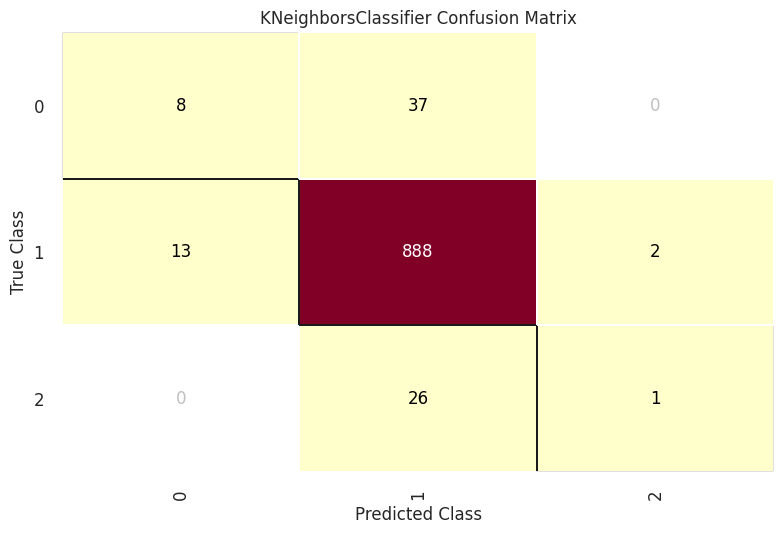

ConfusionMatrix(ax=<Axes: title={'center': 'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=[0, 1, 2],
                cmap=<matplotlib.colors.ListedColormap object at 0x7e6a031cd2d0>,
                estimator=KNeighborsClassifier(n_neighbors=4))

In [23]:
confusion_matrix(LR, X_train, Y_train, X_test, Y_test, classes=classes)

Запустим на 16 соседях и также построим матрицу ошибок

In [24]:
LR = KNeighborsClassifier(n_neighbors = 16)
LR.fit(X_train, Y_train)

LR_training_predict = LR.score(X_train, Y_train)
LR_test_predict = LR.score(X_test, Y_test)

err_train = np.mean(Y_train != LR.predict(X_train))
err_test  = np.mean(Y_test  != LR.predict(X_test))

print("Accuracy. Train : {:.2f}, Test: {:.2f}. ".format(LR_training_predict, LR_test_predict))
print("Error. Train : {:.2f}, Test: {:.2f}. ".format(err_train, err_test))

Accuracy. Train : 0.93, Test: 0.93. 
Error. Train : 0.07, Test: 0.07. 


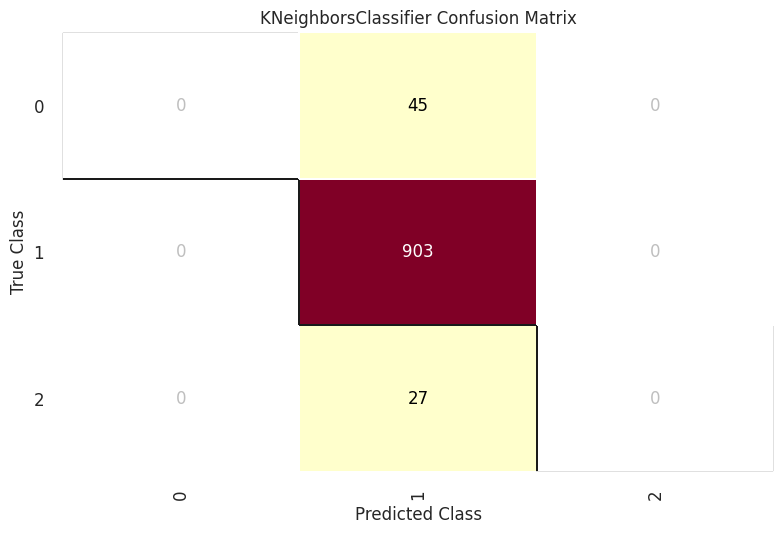

ConfusionMatrix(ax=<Axes: title={'center': 'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=[0, 1, 2],
                cmap=<matplotlib.colors.ListedColormap object at 0x7e6a0302e470>,
                estimator=KNeighborsClassifier(n_neighbors=16))

In [25]:
confusion_matrix(LR, X_train, Y_train, X_test, Y_test, classes=classes)

Запустим для разного количества соседей от 1 до 100, чтобы найти оптимальное число

In [26]:
keighs = np.arange(1, 50, 1)
test_err = []
train_err = []
train_acc = []
test_acc = []

for neigh in keighs:
    mlp_model = KNeighborsClassifier(n_neighbors = neigh)
    mlp_model.fit(X_train, Y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    train_err.append(np.mean(Y_train != y_train_pred))
    test_err.append(np.mean(Y_test != y_test_pred))

    train_acc.append(accuracy_score(Y_train, y_train_pred))
    test_acc.append(accuracy_score(Y_test, y_test_pred))

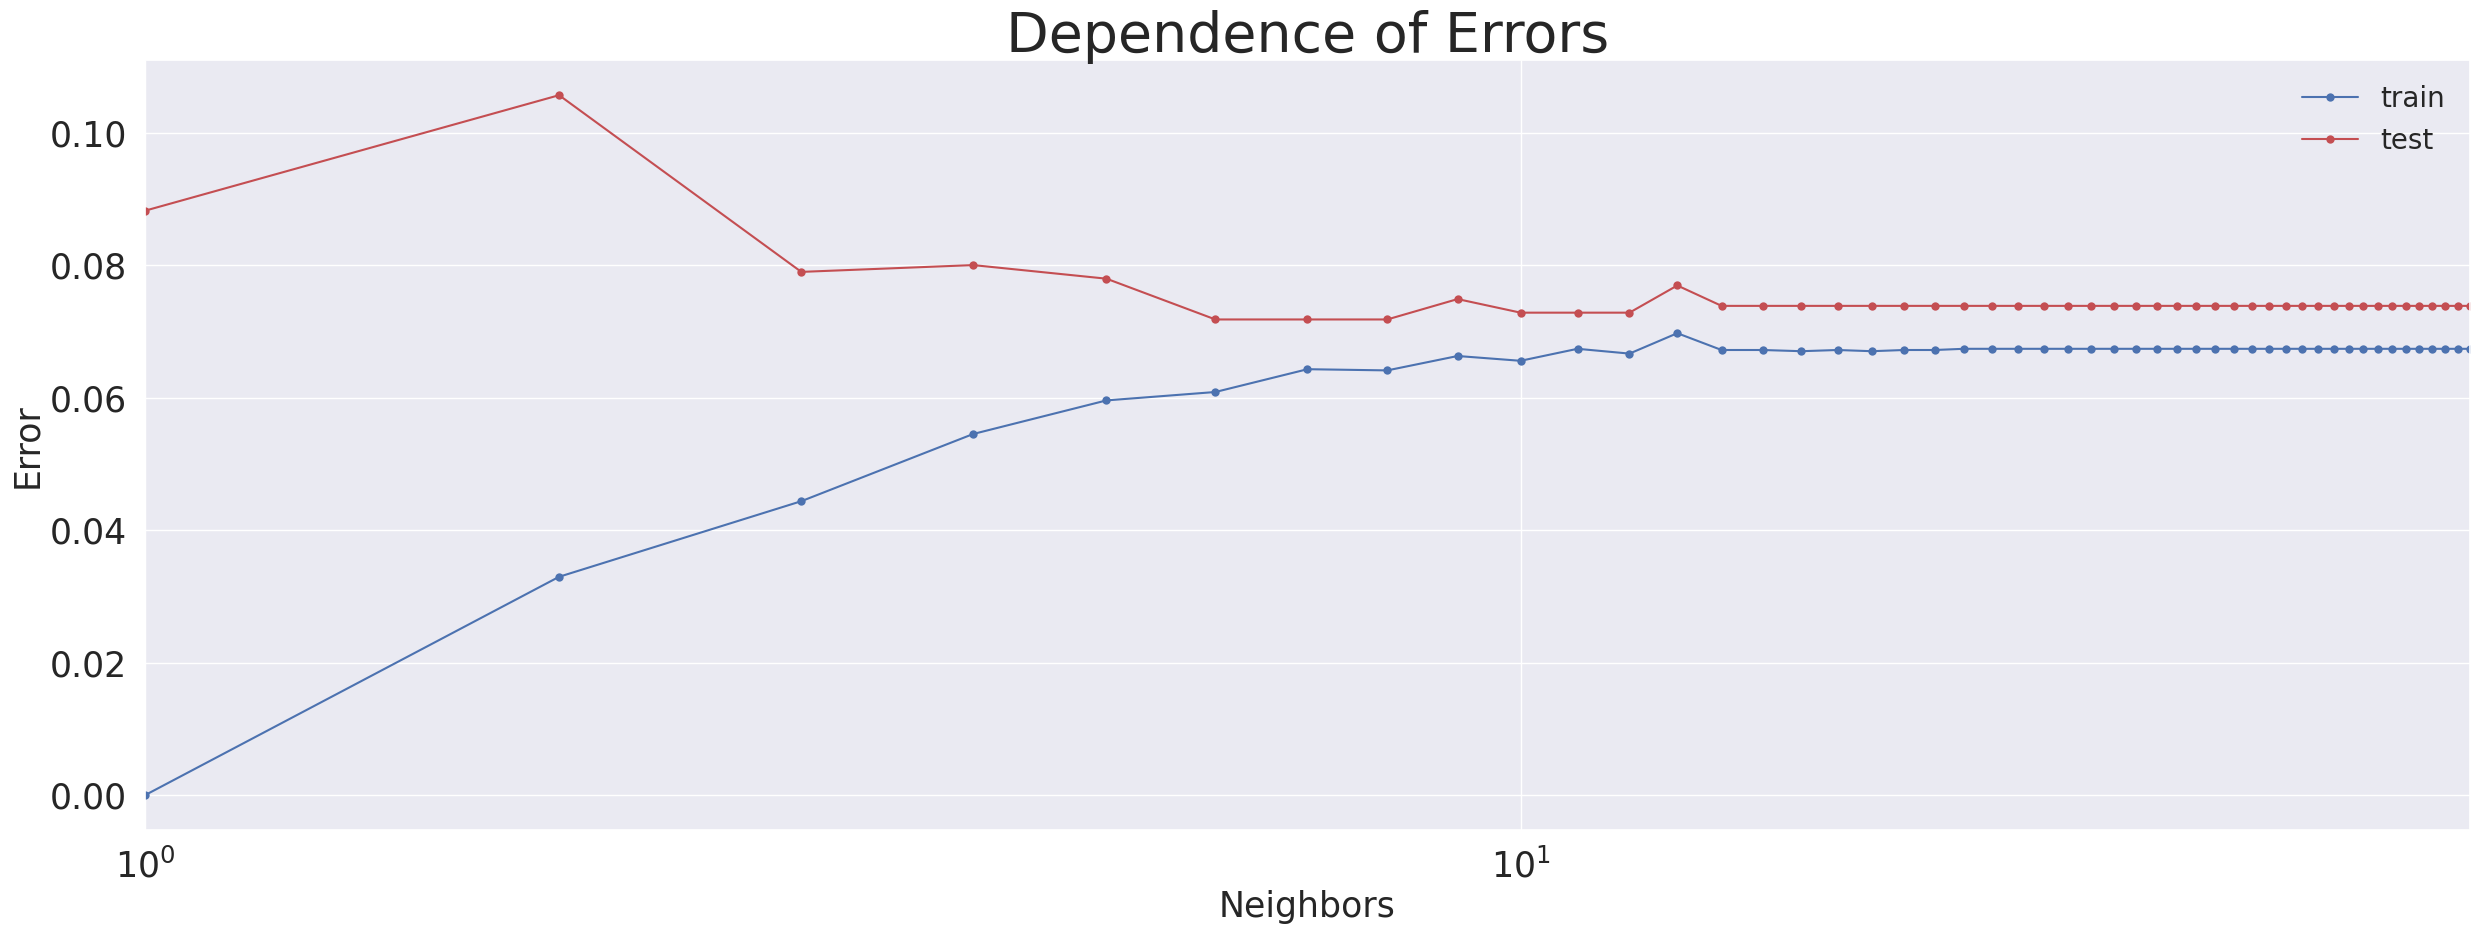

In [27]:
plt.figure(figsize = (30, 10))

plt.semilogx(keighs, train_err, 'b-o', label = 'train')
plt.semilogx(keighs, test_err, 'r-o', label = 'test')

plt.xlim([np.min(keighs), np.max(keighs)])

plt.title('Dependence of Errors', fontsize = 40)
plt.xlabel('Neighbors', fontsize = 25)
plt.ylabel('Error', fontsize = 25)

plt.tick_params(axis='both', which='major', labelsize=25)
plt.tick_params(axis='both', which='minor', labelsize=25)

plt.legend(fontsize = 20)

## ***6 Logistic Regression***


In [28]:
LR = LogisticRegression(max_iter=500)
LR.fit(X_train, Y_train)

LR_training_predict = LR.score(X_train, Y_train)
LR_test_predict = LR.score(X_test, Y_test)

err_train = np.mean(Y_train != LR.predict(X_train))
err_test  = np.mean(Y_test  != LR.predict(X_test))

print("Accuracy. Train : {:.2f}, Test: {:.2f}. ".format(LR_training_predict, LR_test_predict))
print("Error. Train : {:.2f}, Test: {:.2f}. ".format(err_train, err_test))

Accuracy. Train : 0.93, Test: 0.93. 
Error. Train : 0.07, Test: 0.07. 


## ***7 RandomForest***




In [29]:
RanForest = RandomForestClassifier(n_estimators = 100)
RanForest.fit(X_train, Y_train)

RanForest_training_predict = RanForest.score(X_train, Y_train)
RanForest_test_predict = RanForest.score(X_test, Y_test)

err_train = np.mean(Y_train != RanForest.predict(X_train))
err_test  = np.mean(Y_test  != RanForest.predict(X_test))

print("Accuracy. Train : {:.2f}, Test: {:.2f}. ".format(RanForest_training_predict, RanForest_test_predict))
print("Error. Train : {:.2f}, Test: {:.2f}. ".format(err_train, err_test))

Accuracy. Train : 1.00, Test: 0.94. 
Error. Train : 0.00, Test: 0.06. 


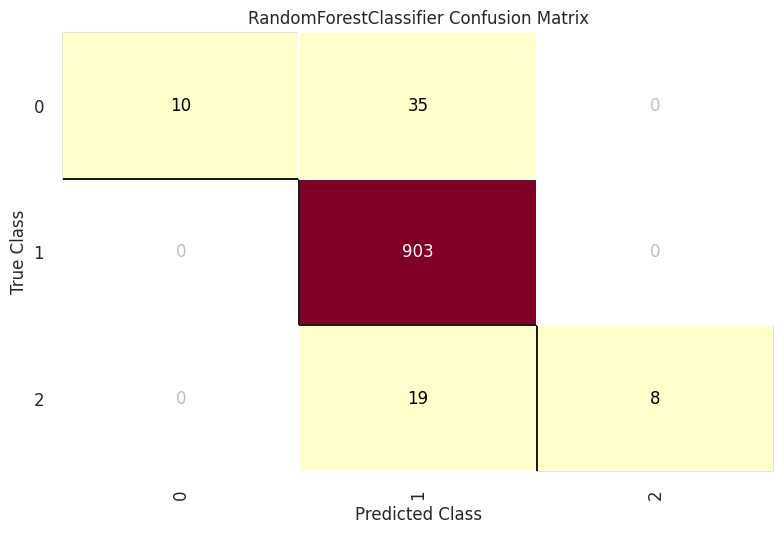

ConfusionMatrix(ax=<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=[0, 1, 2],
                cmap=<matplotlib.colors.ListedColormap object at 0x7e6a02e5fd90>,
                estimator=RandomForestClassifier())

In [30]:
confusion_matrix(RanForest, X_train, Y_train, X_test, Y_test, classes=classes)

In [31]:
maxdepths = np.arange(1, 150, 1)
test_err = []
train_err = []
train_acc = []
test_acc = []

for maxdepth in maxdepths:
    mlp_model = RandomForestClassifier(n_estimators = 100, max_depth = maxdepth)
    mlp_model.fit(X_train, Y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    train_err.append(np.mean(Y_train != y_train_pred))
    test_err.append(np.mean(Y_test != y_test_pred))

    train_acc.append(accuracy_score(Y_train, y_train_pred))
    test_acc.append(accuracy_score(Y_test, y_test_pred))

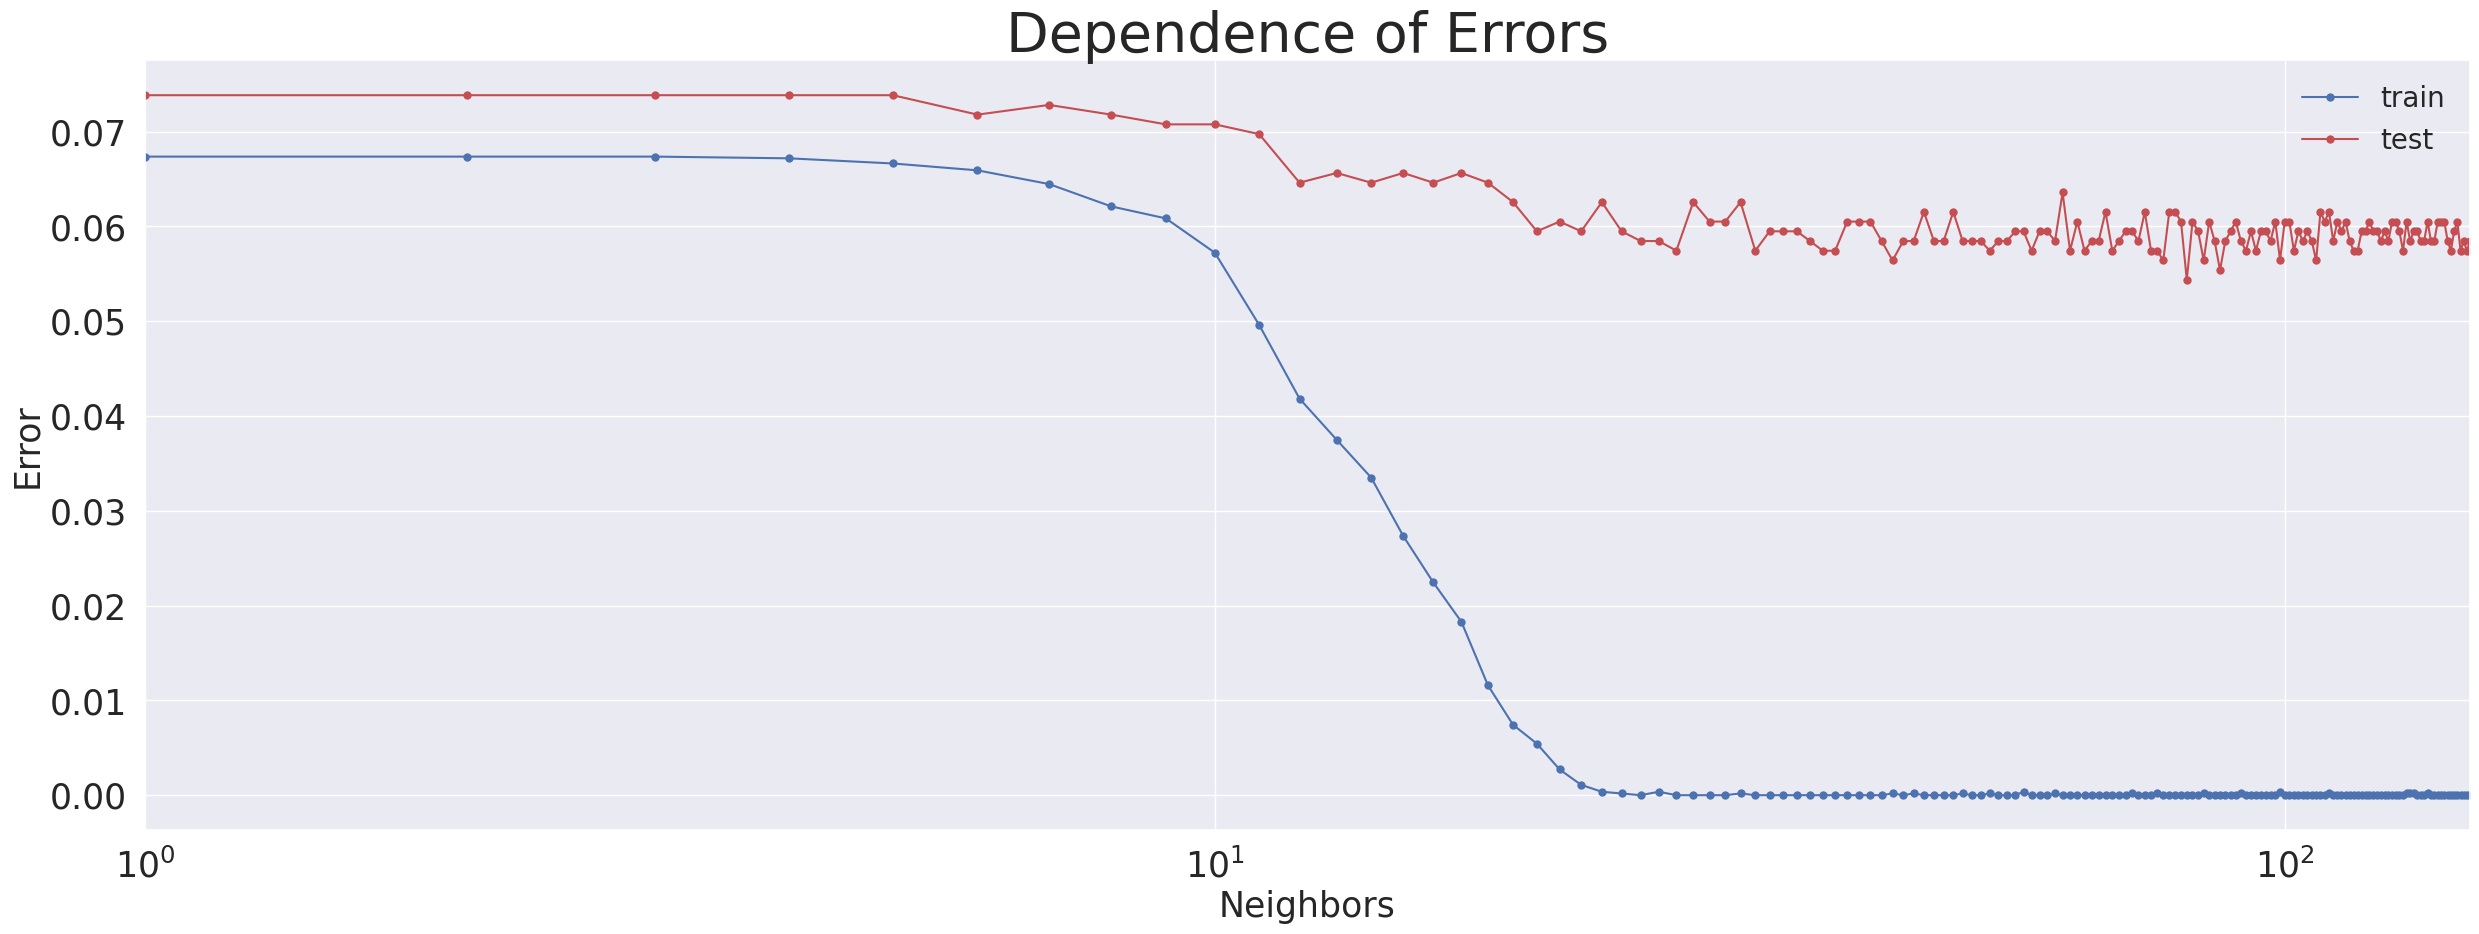

In [32]:
plt.figure(figsize = (30, 10))

plt.semilogx(maxdepths, train_err, 'b-o', label = 'train')
plt.semilogx(maxdepths, test_err, 'r-o', label = 'test')

plt.xlim([np.min(maxdepths), np.max(maxdepths)])

plt.title('Dependence of Errors', fontsize = 40)
plt.xlabel('Neighbors', fontsize = 25)
plt.ylabel('Error', fontsize = 25)

plt.tick_params(axis='both', which='major', labelsize=25)
plt.tick_params(axis='both', which='minor', labelsize=25)

plt.legend(fontsize = 20)